# CS3315 Project: MLP with Keras

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron

In [2]:
# import data
filename = 'data/2020.06.19.csv'
df = pd.read_csv(filename)

# sample small subset
# df = df.sample(500000, random_state=78)
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765360 entries, 0 to 765359
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        765360 non-null  float64
 1   bytes_in       765360 non-null  int64  
 2   bytes_out      765360 non-null  int64  
 3   dest_ip        765360 non-null  int64  
 4   dest_port      740863 non-null  float64
 5   entropy        765360 non-null  float64
 6   num_pkts_out   765360 non-null  int64  
 7   num_pkts_in    765360 non-null  int64  
 8   proto          765360 non-null  int64  
 9   src_ip         765360 non-null  int64  
 10  src_port       740863 non-null  float64
 11  time_end       765360 non-null  int64  
 12  time_start     765360 non-null  int64  
 13  total_entropy  765360 non-null  float64
 14  label          765360 non-null  object 
 15  duration       765360 non-null  float64
dtypes: float64(6), int64(9), object(1)
memory usage: 93.4+ MB


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,7.5,342,3679,786,9200.0,5.436687,2,2,6,786,57392.0,1592533725648144,1592533725632946,21860.918,benign,0.015198
1,0.0,0,0,786,55972.0,0.000000,1,1,6,49453,49493.0,1592533744644904,1592533744644904,0.000,outlier,0.000000


In [3]:
# clean data
df.dropna(inplace=True)
df.isna().sum()

# need to clean for features that are 0 and don't make sense (bytes = 0?)

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

In [4]:
print('label values:', df['label'].unique())

def ordinal_encoder(category):
    dict = {'benign':0, 'outlier':1, 'malicious':2}
    return dict[category]

print('benign', ordinal_encoder('benign'))
print('outlier', ordinal_encoder('outlier'))
print('malicious', ordinal_encoder('malicious'))
df['label'] = df['label'].apply(ordinal_encoder)

label values: ['benign' 'outlier' 'malicious']
benign 0
outlier 1
malicious 2


In [5]:
features = ['avg_ipt', 
            'bytes_in', 
            'bytes_out', 
            'dest_ip', 
            'dest_port', 
            'entropy', 
            'num_pkts_in',
            'num_pkts_out', 
            'proto', 
            'src_ip', 
            'src_port', 
            'time_end', 
            'time_start', 
            'total_entropy', 
            'duration']

X = df.loc[:, features]
y = df.loc[:,'label']

In [6]:
# Scale features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# try PolyScaler?

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [7]:
# test/train split

from sklearn.model_selection import train_test_split

# 80/20 training/validation split
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=.8, test_size=.2, random_state=42)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# should print number of shape: (num features, num entries)
print('Training set: ', 'X: ', X_train.shape, 'y: ', y_train.shape, 'Validation set: ', 'X: ', X_val.shape, 'printy: ', y_val.shape)

print(X_train[1])
print(y_train[1])


Training set:  X:  (592690, 15) y:  (592690,) Validation set:  X:  (148173, 15) printy:  (148173,)
[-0.05565213 -0.24851657 -0.4012423  -0.13191521 -0.1413975  -1.3449873
 -0.27015576 -0.2850236  -0.40847424 -0.50115682  0.54239382  0.33245924
  0.33237538 -0.20292837 -0.33436206]
0


In [8]:
# import tensorflow and keras

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

import os

2022-12-01 20:11:34.181032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0-dev20221112
2.12.0


In [9]:
# keras sequential API model (pg 299)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])
print(X_train.shape[1])

model.summary()

15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               4800      
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 65,603
Trainable params: 65,603
Non-trainable params: 0
_________________________________________________________________


In [10]:
# TODO: adjust kernel initializer or bias initializer? 
# https://keras.io/initializers/

In [11]:
# compile the model
model.compile(loss="sparse_categorical_crossentropy",
             optimizer = "adam",
             metrics="accuracy")

In [12]:
# train the model
num_epochs=30
print(X_train.shape)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs,
                    validation_data=(X_val, y_val))

# loss is nan -> probably indicative of exploding gradients -- try again when we normalize/scale features

(592690, 15)
Epoch 1/30
18522/18522 [==============================] - 36s 2ms/step - loss: 0.1993 - accuracy: 0.9124 - val_loss: 0.1757 - val_accuracy: 0.9210
Epoch 2/30
18522/18522 [==============================] - 34s 2ms/step - loss: 0.1467 - accuracy: 0.9387 - val_loss: 0.1395 - val_accuracy: 0.9430
Epoch 3/30
18522/18522 [==============================] - 34s 2ms/step - loss: 0.1299 - accuracy: 0.9459 - val_loss: 0.1327 - val_accuracy: 0.9474
Epoch 4/30
18522/18522 [==============================] - 34s 2ms/step - loss: 0.1217 - accuracy: 0.9491 - val_loss: 0.1217 - val_accuracy: 0.9503
Epoch 5/30
18522/18522 [==============================] - 34s 2ms/step - loss: 0.1157 - accuracy: 0.9510 - val_loss: 0.1102 - val_accuracy: 0.9567
Epoch 6/30
18522/18522 [==============================] - 33s 2ms/step - loss: 0.1092 - accuracy: 0.9538 - val_loss: 0.1061 - val_accuracy: 0.9577
Epoch 7/30
18522/18522 [==============================] - 33s 2ms/step - loss: 0.1029 - accuracy: 0.9564 

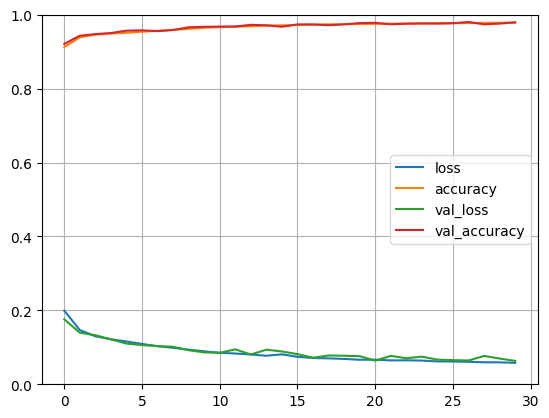

In [13]:
# plot loss vs. accuracy (HOML p. 305)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
# save model
#model.save("project_mlp_2_layers")

In [15]:
# test predictions
X_new = X_val
test_pred = np.argmax(model.predict(X_new), axis=-1)


4631/4631 [==============================] - 4s 775us/step


In [16]:
from sklearn.metrics import *
print("Predicted labels:\t", test_pred)
print("Actual labels:\t\t", y_val)
print(classification_report(y_val, test_pred))

Predicted labels:	 [0 1 0 ... 2 2 1]
Actual labels:		 [0 1 0 ... 2 2 1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75511
           1       0.96      0.92      0.94     24572
           2       0.96      0.98      0.97     48090

    accuracy                           0.98    148173
   macro avg       0.97      0.97      0.97    148173
weighted avg       0.98      0.98      0.98    148173



## Validate Model with Data from June 2022

In [17]:
# import data
filename = 'data/2020.06.20.csv'
df2 = pd.read_csv(filename)

# sample small subset
#df2 = df2.sample(n=100000, random_state=78)
df2.info()
df2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770853 entries, 0 to 770852
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   avg_ipt        770853 non-null  float64
 1   bytes_in       770853 non-null  int64  
 2   bytes_out      770853 non-null  int64  
 3   dest_ip        770853 non-null  int64  
 4   dest_port      770853 non-null  int64  
 5   entropy        770853 non-null  float64
 6   num_pkts_out   770853 non-null  int64  
 7   num_pkts_in    770853 non-null  int64  
 8   proto          770853 non-null  int64  
 9   src_ip         770853 non-null  int64  
 10  src_port       770853 non-null  int64  
 11  time_end       770853 non-null  int64  
 12  time_start     770853 non-null  int64  
 13  total_entropy  770853 non-null  float64
 14  label          770853 non-null  object 
 15  duration       770853 non-null  float64
dtypes: float64(4), int64(11), object(1)
memory usage: 94.1+ MB


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,34.57143,34,29,786,5900,5.040459,7,10,6,28753,34406,1592614653171313,1592614652702811,317.5489,malicious,0.468502
1,37.00000,34,29,786,5900,5.127916,7,10,6,28753,29250,1592614652343948,1592614651847887,323.0587,malicious,0.496061


In [18]:
# clean data
df2.dropna(inplace=True)
df2.isna().sum()

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

In [19]:
print('label values:', df2['label'].unique())

def ordinal_encoder(category):
    dict = {'benign':0, 'outlier':1, 'malicious':2}
    return dict[category]

print('benign', ordinal_encoder('benign'))
print('outlier', ordinal_encoder('outlier'))
print('malicious', ordinal_encoder('malicious'))
df2['label'] = df2['label'].apply(ordinal_encoder)

label values: ['malicious' 'benign' 'outlier']
benign 0
outlier 1
malicious 2


In [20]:
features = ['avg_ipt', 
            'bytes_in', 
            'bytes_out', 
            'dest_ip', 
            'dest_port', 
            'entropy', 
            'num_pkts_in',
            'num_pkts_out', 
            'proto', 
            'src_ip', 
            'src_port', 
            'time_end', 
            'time_start', 
            'total_entropy', 
            'duration']

X_22 = df2.loc[:, features]
y_22 = df2.loc[:,'label']

In [21]:
# Scale features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# try PolyScaler?

scaler = StandardScaler()
scaler.fit(X_22)
X_22 = scaler.transform(X_22)

# change labels to numpy
y_22 = y_22.to_numpy()

In [22]:
# test predictions
X_test_new = X_22
test_pred_22 = np.argmax(model.predict(X_test_new), axis=-1)

24090/24090 [==============================] - 19s 778us/step


In [23]:
print("Predicted labels:\t", test_pred_22)
print("Actual labels:\t\t", y_22)
print(classification_report(y_22, test_pred_22))

Predicted labels:	 [2 2 2 ... 2 2 2]
Actual labels:		 [2 2 2 ... 1 1 2]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    366310
           1       0.26      0.23      0.24     69389
           2       0.76      0.88      0.82    335154

    accuracy                           0.82    770853
   macro avg       0.67      0.66      0.66    770853
weighted avg       0.83      0.82      0.82    770853

